By [Kevin Michalewicz](https://kevinmichalewicz.com) on May 2023

This notebook discusses feature interpretation in the context of ANTIPASTI.

In [1]:
# General imports
import cv2
import glob
import itertools
import os
import pandas as pd
import numpy as np
import subprocess
import torch

from copy import deepcopy
from matplotlib.colors import CenteredNorm

# for reading and displaying images
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch-related libraries
from adabelief_pytorch import AdaBelief

# ANTIPASTI
from antipasti.model.model import ANTIPASTI
from antipasti.preprocessing.preprocessing import Preprocessing
from antipasti.utils.explaining_utils import compute_change_in_kd, get_epsilon, get_maps_of_interest, map_residues_to_regions
from antipasti.utils.torch_utils import load_checkpoint

# Loading results

In [46]:
# Parameters
modes = 30
n_filters = 1
filter_size = 4
pooling_size = 2
n_max_epochs = 1112

mode = 'fully-extended' # Choose between 'fully-extended' and 'fully-cropped'
pathological = ['5omm', '1mj7', '1qfw', '1qyg', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t']
stage = 'predicting'
regions = 'heavy'

test_data_path = '../notebooks/test_data/'
test_dccm_map_path = 'dccm_map/'
test_residues_path = 'list_of_residues/'
test_structure_path = 'structure/'

# Pre-processing
preprocessed_data = Preprocessing(modes=modes, pathological=pathological, regions=regions, mode=mode, stage=stage, test_data_path=test_data_path, test_dccm_map_path=test_dccm_map_path, test_residues_path=test_residues_path, test_structure_path=test_structure_path)
input_shape = preprocessed_data.test_x.shape[-1]

# Loading the actual checkpoint and learnt filters
path = '../checkpoints/model_' + regions + '_epochs_' + str(n_max_epochs) + '_modes_' + str(modes) + '_pool_' + str(pooling_size) + '_filters_' + str(n_filters) + '_size_' + str(filter_size) + '.pt'
model = load_checkpoint(path, input_shape)[0]
learnt_filter = np.load('../checkpoints/learnt_filter_'+regions+'_epochs_'+str(n_max_epochs)+'_modes_'+str(modes)+'_pool_'+str(pooling_size)+'_filters_'+str(n_filters)+'_size_'+str(filter_size)+'.npy')
model.eval()

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


ANTIPASTI(
  (conv1): Conv2d(1, 1, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropit): Dropout(p=0.05, inplace=False)
  (relu): ReLU()
  (fc1): Linear(in_features=3136, out_features=1, bias=False)
)

# Obtaining maps of interest

In [47]:
title_size = 20
font_size = 14

mean_learnt, mean_image, mean_diff_image = get_maps_of_interest(preprocessed_data, learnt_filter)

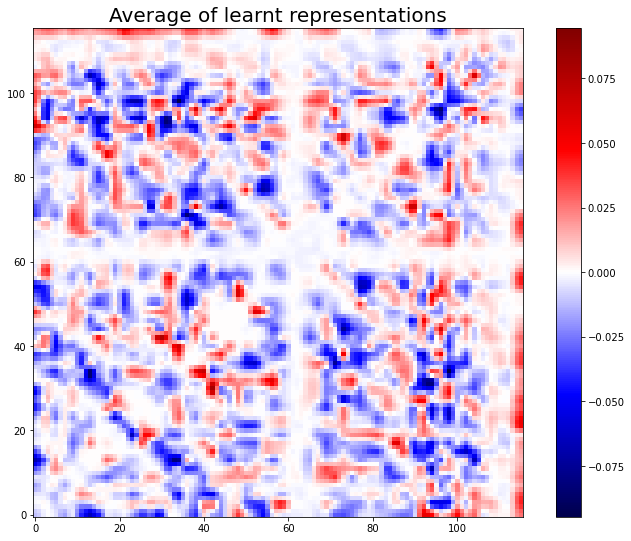

In [48]:
fig = plt.figure(figsize=(12, 9))
plt.imshow(mean_learnt, origin='lower', cmap='seismic', norm=CenteredNorm())
plt.title('Average of learnt representations', size=title_size)
plt.colorbar()
plt.show()

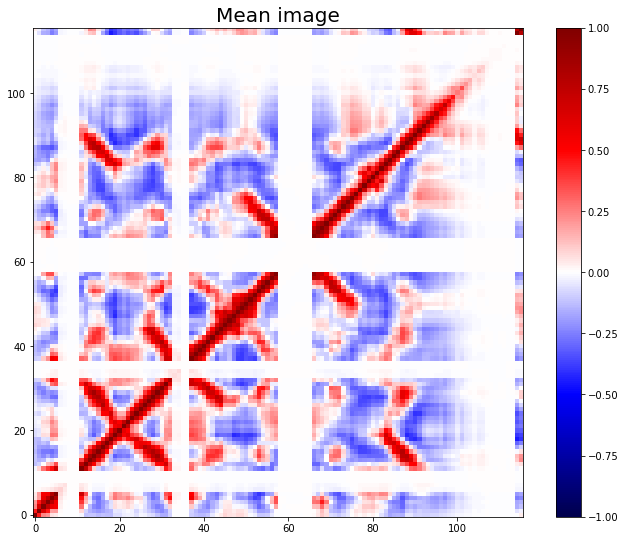

In [49]:
fig = plt.figure(figsize=(12, 9))
plt.imshow(mean_image, origin='lower', cmap='seismic', norm=CenteredNorm())
plt.title('Mean image', size=title_size)
plt.colorbar()
plt.show()

In [50]:
preprocessed_data.train_x[0][47,:].sum()

2.3107017908034964

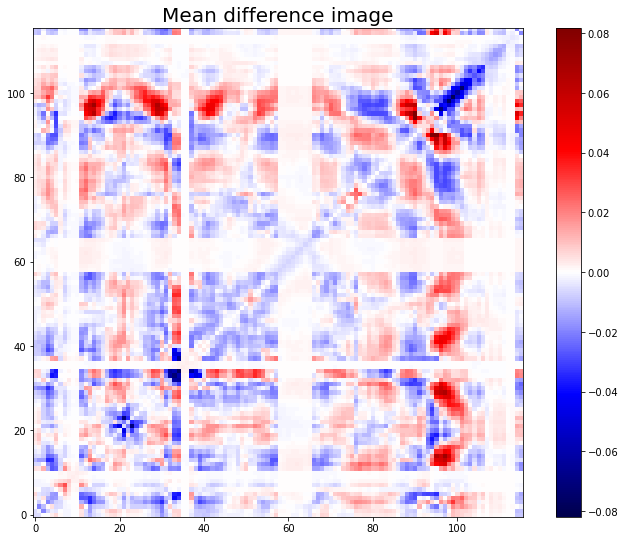

In [51]:
fig = plt.figure(figsize=(12, 9))
plt.imshow(mean_diff_image, origin='lower', cmap='seismic', norm=CenteredNorm())
plt.title('Mean difference image', size=title_size)
plt.colorbar()
plt.show()

# Obtaining $\epsilon$

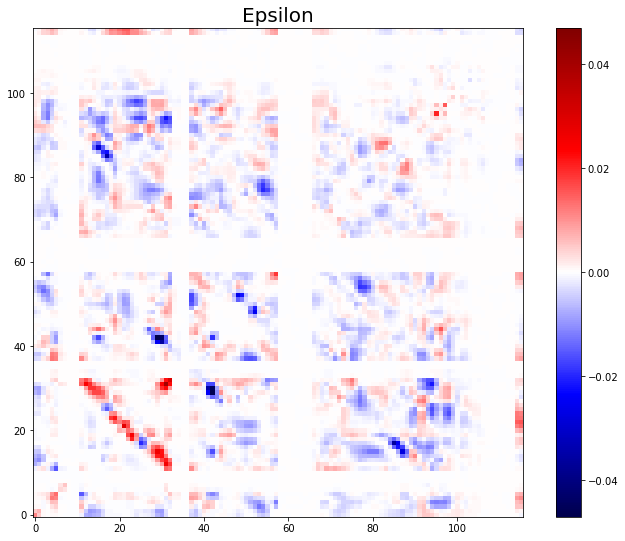

In [52]:
epsilon = get_epsilon(preprocessed_data, model, mean_diff_image)

fig = plt.figure(figsize=(12, 9))
plt.imshow(epsilon, origin='lower', cmap='seismic', norm=CenteredNorm())
plt.title('Epsilon', size=title_size)
plt.colorbar()
plt.show()

# Finding correlations between actual strucutres

In [53]:
coord, maps, ticks, ticks_labels, titles, rmax = map_residues_to_regions(preprocessed_data, epsilon)

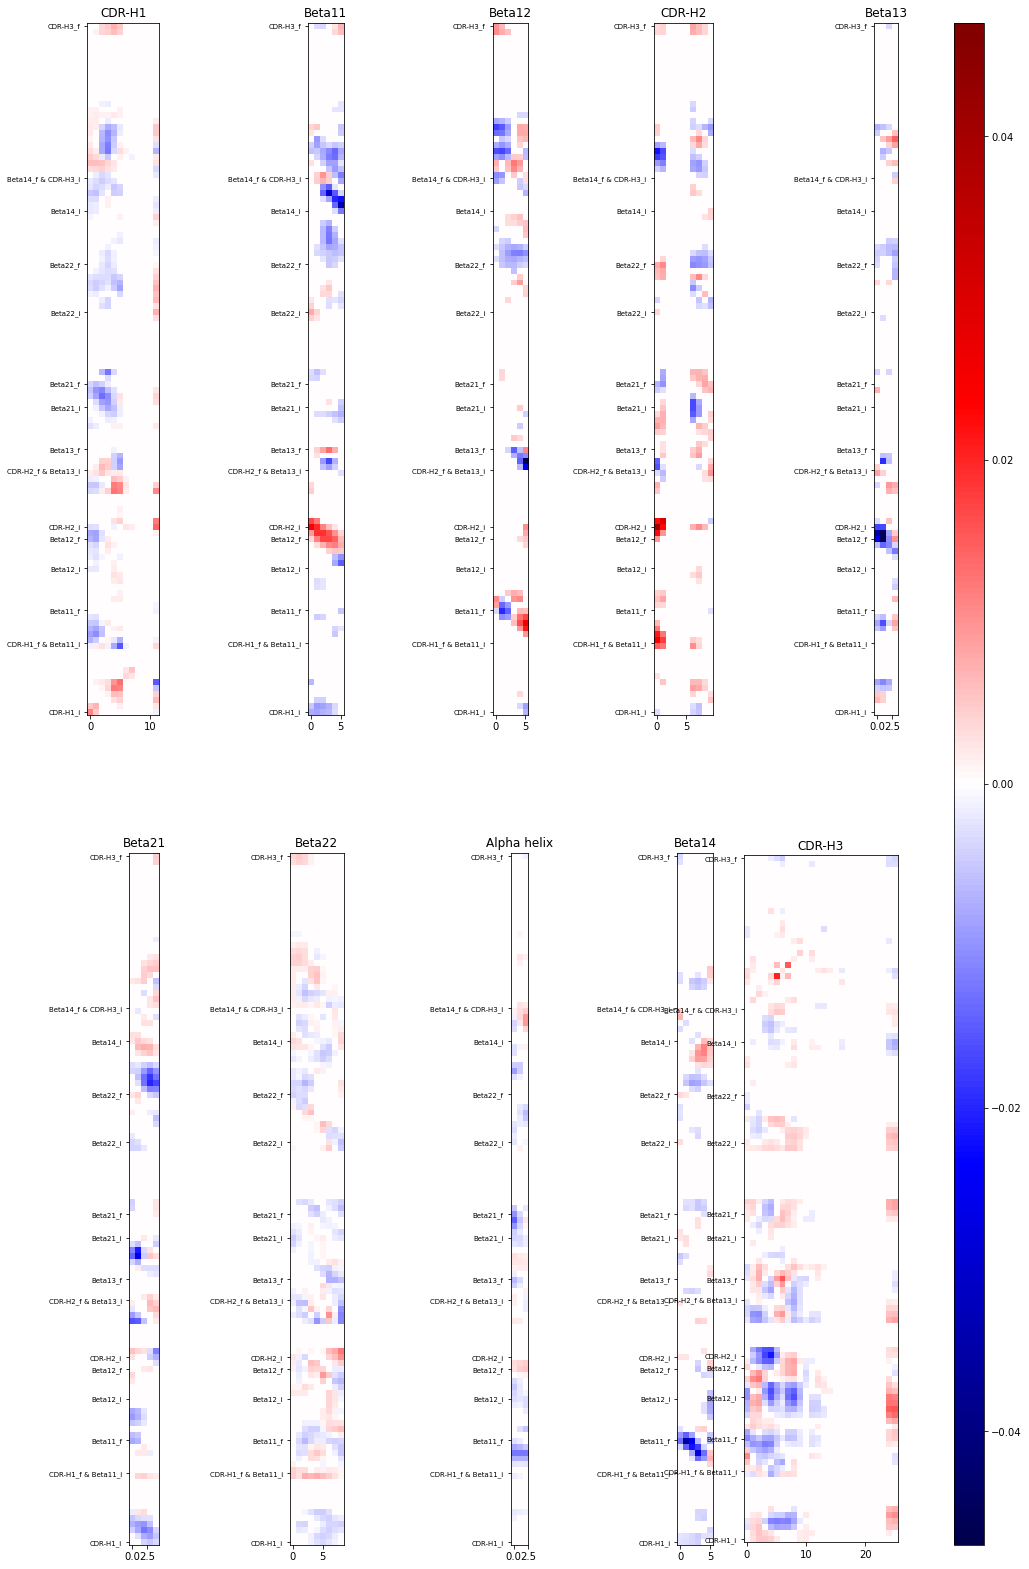

In [54]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 28))
for i, row in enumerate(axs):
    for j, col in enumerate(row):
        corr_h = maps[5*i+j]
        im = axs[i,j].imshow(np.where(abs(corr_h)<abs(corr_h).max()/15, 0, corr_h), origin='lower', cmap='seismic', norm=CenteredNorm(halfrange=rmax))
        axs[i,j].set_yticks(ticks, ticks_labels, fontsize=7) 
        axs[i,j].set_title(titles[5*i+j])
fig.colorbar(im, ax=axs.ravel().tolist(), aspect=50)
plt.show()

# Change in $K_D$ when adding $\epsilon$

In [55]:
# Here it is possible to tune the weight of each antibody region

cdr3_factor_h = 0.1 
cdr1_factor_h = 0.1 
cdr2_factor_h = 0.1 
beta11_factor_h = 0.1 
beta12_factor_h = 0.1 
beta13_factor_h = 0.1 
beta14_factor_h = 0.1 
beta21_factor_h = 0.1 
beta22_factor_h = 0.1 
alpha_factor_h = 0.1 

# Expressing as vector
weights = np.array([cdr1_factor_h, beta11_factor_h, beta12_factor_h, cdr2_factor_h, beta13_factor_h, beta21_factor_h, beta22_factor_h, alpha_factor_h, beta14_factor_h, cdr3_factor_h])

compute_change_in_kd(preprocessed_data, model, weights, coord, maps)

Without adding epsilon, Kd = 1.6190259e-07
After adding epsilon, Kd = 1.5243928e-07
Thus, Kd is smaller by 5.845062 %
